# Precision-Recall Monte-Carlo
This notebook explores how the precision-recall curves are affected by different Norbits_instability values. The essence of this notebook is as follows:  
1) Using sim_id = 4002 and 4283 we get a sense of the standard deviation in log(Norbits_instability). We assume that all sim_ids have the same spread in Norbits_Instability.  
2) Randomly generate new Norbits_Instability times for each sim_id by drawing from gaussian distributions, where the mean is the "true" Norbits_Instability time and standard deviation calculated from 1).   
3) If Norbits_Instability < 1e6, then the newly drawn system is classified as unstable, otherwise it is stable.  
4) Generate new precision-recall curves.

* Dealing with Norbits_instability = 10^7 systems: Maybe it goes unstable after 10^9 years, and assuming that the mean of the distribution is 10^7 is thus incorrect. But maybe if we see the slope the rate of how systems go unstable, fit a curve to that, and then extend it, we can draw mean instability times for the systems with Norbits_instability = 10^7.  

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
sim_id = 4002
#df = pd.read_csv("/mnt/raid-cita/dtamayo/Stability/data/distribution/outputs"+str(sim_id)+'/distribution'+str(sim_id)+".csv", index_col=0)
df = pd.read_csv("../data/distribution/outputs"+str(sim_id)+'/distribution'+str(sim_id)+".csv", index_col=0)
df.tail()

sim_id = 4283
#df2 = pd.read_csv("/mnt/raid-cita/dtamayo/Stability/data/distribution/outputs"+str(sim_id)+'/distribution'+str(sim_id)+".csv", index_col=0)
df2 = pd.read_csv("../data/distribution/outputs"+str(sim_id)+'/distribution'+str(sim_id)+".csv", index_col=0)
df2.tail()

,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,inc1,...,Omega3,f3,x3,y3,z3,vx3,vy3,vz3,Rel_Eerr,integ_time
Sim_ID,,,,,,,,,,,,,,,,,,,,,
995,False,4.220480e+06,10000000.0,0.000015,0.021544,0.045652,0.009754,0.013522,1.325028,0.004092,...,-1.946087,-4.701002,-0.04958,0.035818,-0.000597,-15.283265,-20.29633,-0.068275,0.000133,188.618895
996,False,2.797826e+06,10000000.0,0.000015,0.021544,0.045652,0.009754,0.013522,1.325028,0.004092,...,-1.946087,-4.701002,-0.04958,0.035818,-0.000597,-15.283265,-20.29633,-0.068275,0.000038,126.096676
997,False,2.938650e+06,10000000.0,0.000015,0.021544,0.045652,0.009754,0.013522,1.325028,0.004092,...,-1.946087,-4.701002,-0.04958,0.035818,-0.000597,-15.283265,-20.29633,-0.068275,0.000031,131.513661
998,False,1.744611e+07,10000000.0,0.000015,0.021544,0.045652,0.009754,0.013522,1.325028,0.004092,...,-1.946087,-4.701002,-0.04958,0.035818,-0.000597,-15.283265,-20.29633,-0.068275,0.006207,777.151159
999,False,2.035919e+06,10000000.0,0.000015,0.021544,0.045652,0.009754,0.013522,1.325028,0.004092,...,-1.946087,-4.701002,-0.04958,0.035818,-0.000597,-15.283265,-20.29633,-0.068275,0.001526,91.547254


In [19]:
logs1 = np.log10(df['Norbits_instability'].values)
logs2 = np.log10(df2['Norbits_instability'].values)

0.338423941975 0.458251312576


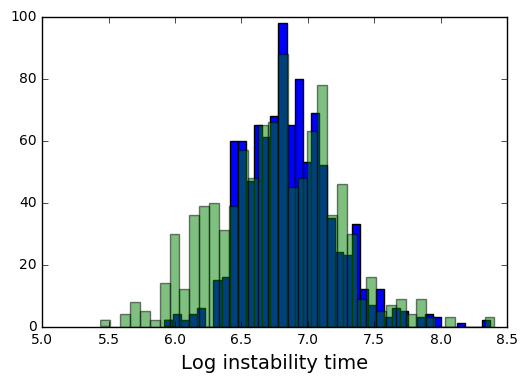

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(logs1, 40)
ax.hist(logs2, 40, alpha=0.5)
ax.set_xlabel('Log instability time', fontsize=14)
print np.std(logs1),np.std(logs2)

In [30]:
from scipy.stats import norm
mu1, std1 = norm.fit(logs1)
mu2, std2 = norm.fit(logs2)
std_avg = np.mean([std1,std2])

In [125]:
data = pd.read_csv("../data/ari_mc.csv",header=0)
data.head()

#change stability to if systems survive > 10^6 years
thresh_stability=6
data.loc[np.log10(data["Norbits_instability"])>=thresh_stability,"Stable"] = True
data.head()

,Sim_ID,daOverRH1,daOverRH2,P2/P1,P3/P2,predprob,predstable,Norbits_instability,Stable
0,1648,6.879240,7.131643,1.230348,1.239099,0.264850,False,1.000000e+07,True
1,3471,8.496936,5.371167,1.286789,1.178497,0.012564,False,8.233677e+05,False
2,3849,6.822671,5.825163,1.228390,1.194028,0.005195,False,7.204145e+03,False
3,3537,5.092680,6.103170,1.169004,1.203572,0.011169,False,5.851915e+03,False
4,4214,8.928228,5.186531,1.301979,1.172200,0.076634,False,6.435885e+06,True


In [156]:
def PR_MC(data, std_avg, thresh_stability, N_samples):
    precision = []
    recall = []
    
    #fig, ax = plt.subplots()
    for i in range(N_samples):
        #Monte-Carlo
        data["sample_log_NorbInsta"] = np.random.normal(loc=np.log10(data["Norbits_instability"]), scale=2*std_avg)
        #ax.hist(data["sample_log_NorbInsta"], 40, alpha=0.3, label="");
        
        #pos = postive result, i.e. Stable. 
        true_pos_and_pos_classify = data[(data["Stable"]==1)&(data["sample_log_NorbInsta"]>thresh_stability)].shape[0]
        pos_classify = data[data["sample_log_NorbInsta"]>thresh_stability].shape[0]
        total_true_pos = data[data["Stable"]==1].shape[0]
        precision.append(true_pos_and_pos_classify/float(pos_classify))
        recall.append(true_pos_and_pos_classify/float(total_true_pos))
    
    #ax.hist(np.log10(data["Norbits_instability"]), 40, alpha=0.3, label="original dist");
    #plt.legend(loc="upper left")
    #ax.set_title("Difference between MC samples and original")
    #ax.set_xlabel("log10(Norbits_instability)")
    #plt.savefig("precision-recall_MC_sample-dist.pdf")
    return precision, recall, data

In [157]:
N_samples = 1000
precision, recall, data = PR_MC(data,std_avg,thresh_stability,N_samples)

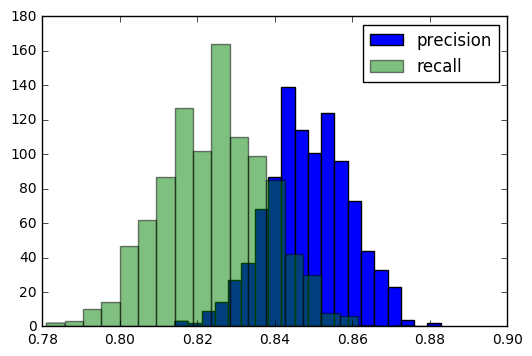

In [158]:
fig, ax = plt.subplots()
ax.hist(precision, 20, label="precision");
ax.hist(recall, 20, alpha=0.5, label="recall");
plt.legend(loc="upper right")
plt.savefig("precision-recall_MC_2xstd.pdf")

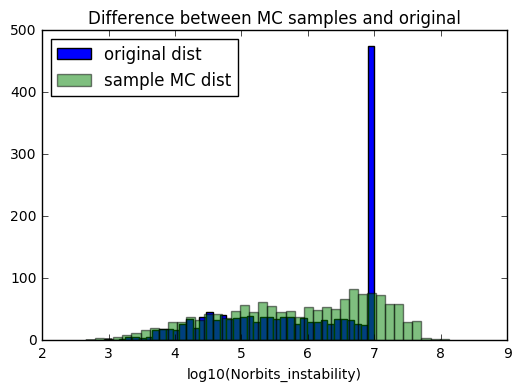

In [154]:
fig, ax = plt.subplots()
ax.hist(np.log10(data["Norbits_instability"]), 40, label="original dist");
ax.hist(data["sample_log_NorbInsta"], 40, alpha=0.5, label="sample MC dist");
plt.legend(loc="upper left")
ax.set_title("Difference between MC samples and original")
ax.set_xlabel("log10(Norbits_instability)")

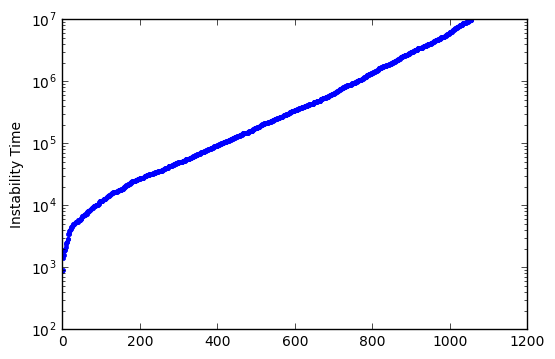

In [78]:
insta_time = data.loc[data["Norbits_instability"]<1e7,"Norbits_instability"]
plt.plot(np.sort(insta_time),'.')
plt.yscale('log')
plt.ylabel('Instability Time')
#plt.savefig("instability-time.pdf")

In [4]:
df['Norbits_instability'].mean()

10536330.846826443

In [5]:
df['Norbits_instability'].std()

15261284.272998041

In [6]:
dfdist = pd.read_csv('../data/distribution/outputs'+str(sim_id)+'/distributionallfeatures'+str(sim_id)+'.csv', index_col=0)
#dfdist = pd.read_csv('/mnt/raid-cita/dtamayo/Stability/data/distribution/outputs'+str(sim_id)+'/distributionallfeatures'+str(sim_id)+'.csv', index_col=0)

In [10]:
dfdist.head()

,Sim_ID,Stable,Norbits_instability,Norbits,Mplanet,RH/a,a1,P1,e1,pomega1,...,max_iH2,max_iH3,min_iH1,min_iH2,min_iH3,mean_std_iH,norm_a1_slope,norm_a2_slope,norm_a3_slope,y_pred
0,0,False,2.699634e+06,10000000.0,0.000015,0.021544,0.058205,0.014042,0.016157,0.160546,...,0.672781,0.502136,0.015138,0.013499,0.176773,0.180753,-5.091637e-12,1.620393e-10,-1.796246e-10,0.942134
1,1,False,6.795081e+06,10000000.0,0.000015,0.021544,0.058205,0.014042,0.016157,0.160546,...,0.672781,0.502136,0.015138,0.013499,0.176773,0.180753,-5.304721e-12,1.622489e-10,-1.796332e-10,0.945562
2,2,False,6.059626e+06,10000000.0,0.000015,0.021544,0.058205,0.014042,0.016157,0.160546,...,0.672781,0.502136,0.015138,0.013499,0.176773,0.180753,-5.083294e-12,1.620311e-10,-1.796243e-10,0.942134
3,3,False,3.425721e+06,10000000.0,0.000015,0.021544,0.058205,0.014042,0.016157,0.160546,...,0.672781,0.502136,0.015138,0.013499,0.176773,0.180753,-5.287510e-12,1.622319e-10,-1.796325e-10,0.945562
4,4,False,6.157578e+06,10000000.0,0.000015,0.021544,0.058205,0.014042,0.016157,0.160546,...,0.672781,0.502136,0.015138,0.013499,0.176773,0.180753,-5.131387e-12,1.620784e-10,-1.796262e-10,0.942082


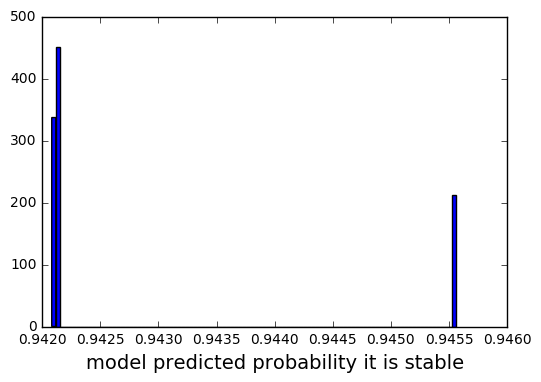

In [11]:
fig, ax = plt.subplots()
ax.hist(dfdist["y_pred"], 100)
ax.set_xlabel('model predicted probability it is stable', fontsize=14)

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(dftest['Stable'], y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')